**Сумма элементов вектора**
Задача: реализовать алгоритм сложения элементов вектора
Язык: C++ или Python
Входные данные: Вектор размером 1 000..1 000 000 значений.
Выходные данные: сумма элементов вектора + время вычисления
Реализация должна содержать 2 функции сложения элементов вектора: на CPU и на
GPU с применением CUDA.
Отчет о проделанной лабораторной работе - это git-репозиторий с исходным кодом
реализации + описание проделанной работы там же в readme.
Необходимо описать реализацию, объяснив, что конкретно было распараллелено и
почему.
Провести эксперименты: получить сумму векторов разных размеров (провести 5 или
более экспериментов), посчитать ускорение. Результаты привести в виде
таблицы/графика.

Импортируем необходмые библиотеки, numba для вычислений на gpu, pyplot для построения графиков и tabulate для предоставления результатов вычислений в удобном виде

In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda
from tabulate import tabulate

Определение параметров для параллельных вычислений, а также функция суммирования значений вектора на GPU

In [8]:
# Количество нитей в блоке (Thread Per Block) для GPU
tpb = 16

# Количество итераций для усреднения времени выполнения
iterations = 70

# эпсилон во избежание ошибки деления на ноль
epsilon = 10e-8


@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x  # Индекс нити в блоке
    bx = cuda.blockIdx.x   # Индекс блока
    idx = tx + bx * tpb    # Индекс элемента в массиве

    if idx < vec.shape[0]:
        cuda.atomic.add(res, 0, vec[idx])


In [9]:

# Функция для проведения измерений на CPU и GPU
def calculation():
    results = []
    vec_size_min = 100000
    vec_size_max = 1000000
    vec_size_interval = 50000

    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        cpu_time_sum = 0.
        gpu_time_sum = 0.

        for _ in range(iterations):
            vec = np.ones(vec_size)
            res = np.zeros(1, dtype=np.int32)

            d_vec = cuda.to_device(vec)  # Отправляем вектор на GPU
            d_res = cuda.to_device(res)  # Создаем массив для результата на GPU

            start = time.time()

            # Вызываем функцию на GPU для суммирования
            gpu_vec_sum[int((vec_size + tpb) / tpb), tpb](d_vec, d_res)

            gpu_time_sum += time.time() - start

            res = d_res.copy_to_host()  # Копируем результат с GPU на CPU

            start = time.time()
            real_res = np.sum(vec)  # Выполняем суммирование на CPU
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

        result = [vec_size,  cpu_time_sum / iterations, gpu_time_sum / iterations]
        results.append(result)

    # Вывод таблицы результатов
    print(tabulate(results, headers=['vector size', 'CPU m.s.', 'GPU m.s.']))
    return results

# Выполняем измерения и сохраняем результаты
output_data = calculation()


  vector size     CPU m.s.     GPU m.s.
-------------  -----------  -----------
       100000  5.50645e-05  0.00151124
       150000  7.31979e-05  8.64778e-05
       200000  8.93865e-05  8.66583e-05
       250000  0.000112694  8.80173e-05
       300000  0.000131106  8.96726e-05
       350000  0.000159989  9.51358e-05
       400000  0.000184304  9.41208e-05
       450000  0.000202428  9.63041e-05
       500000  0.000218528  9.68048e-05
       550000  0.000226038  9.01903e-05
       600000  0.000239382  9.16447e-05
       650000  0.00027851   9.1144e-05
       700000  0.000285922  8.74894e-05
       750000  0.000302921  8.72237e-05
       800000  0.000345952  9.1001e-05
       850000  0.000360073  9.50166e-05
       900000  0.000360159  9.26869e-05
       950000  0.000377931  9.10589e-05
      1000000  0.00039853   9.14063e-05


Создаем Графики для боллее наглядного представления результатов вычислений полученных благодаря ускорениям с помощью CUDA

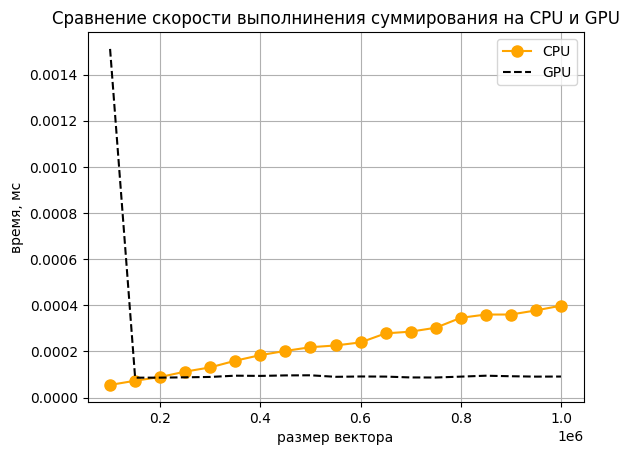

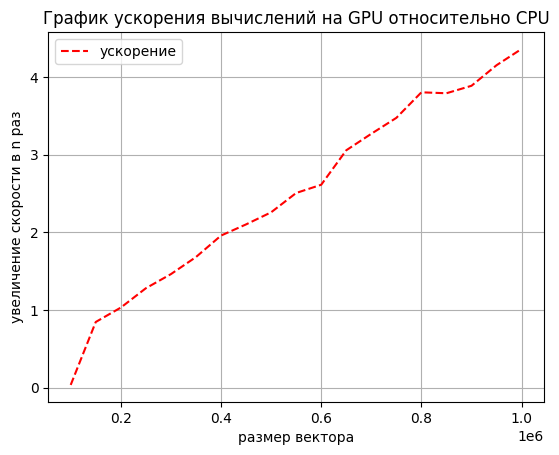

In [10]:
# Функция для построения графиков
def plots(vec_array, cpu_time_array, gpu_time_array, acceleration_array):

    plt.figure()
    plt.plot(vec_array, cpu_time_array, color ='orange', marker ='o', markersize = 8, label = 'CPU')
    plt.plot(vec_array, gpu_time_array, color ='k',
         linestyle ='dashed', label = 'GPU')
    plt.xlabel("размер вектора")
    plt.ylabel("время, мс")
    plt.title('Сравнение скорости выполнинения суммирования на CPU и GPU')
    plt.legend()
    plt.grid()


    plt.figure()
    plt.title("График ускорения вычислений на GPU относительно CPU")
    plt.plot(vec_array, acceleration_array, 'r--', label = 'ускорение')
    plt.ylabel('увеличение скорости в n раз')
    plt.xlabel("размер вектора")
    plt.legend()
    plt.grid()
    plt.show()


# Данные для построения графиков
vec_array = list(map(lambda x: x[0], output_data))
cpu_time_array = list(map(lambda x: x[1], output_data))
gpu_time_array = list(map(lambda x: x[2], output_data))
acceleration_array = list(map(lambda x: x[1] / (x[2] if x[2] > epsilon else epsilon), output_data))

# Строим графики
plots(vec_array, cpu_time_array, gpu_time_array, acceleration_array)

Как можно видеть на графике время выполнения на CPU и GPU на начальном этапе равны, однако на более крупных векторах скорость выполнения на GPU оказывается значительно выше чем на CPU, при этом ярко виден тренд на увеличение разницы по времени между CPU и GPU пропорционально увеличению длины вектора. Параллельные вычисления позволяют GPU выдавать заметно более стабильный результат чем CPU.  